## BC205 Exercise 3: Implementing a simplified version of the FastA algorithm
---

#####  **Author:** Eftychia Kazasi, Georgios Kousis Tsampazis
---

### Overview
In this exercise you may work in pairs or groups of three (maximum).
You will be asked to implement the a simplified version of the FastA algorithm.

For implementation purposes you should consider the following:

1. Take the query sequence that you will find in this [link](https://github.com/christoforos-nikolaou/BC205/blob/master/files/query.fa) to search it against:
2. A set of sequences that contains the total number of coding (gene) sequences of _S. cerevisiae_ that you may find [here](https://www.dropbox.com/s/ilokqlhvez6tvga/all_yeast_genes_minplus1k.fa).
3. You are asked to implement a simplified version of the FastA algorithm using:  
   
   a. a simple score of +1/0 for word matches/mismatches. This means that _S[i]_ will be incremmented by +1 each time a k-mer is found.  

   b. k=5 as the length of the matched word 

   c. m=20 as the minimum size of matched diagonals (_S[i]_) that you will keep in each search  

   d. g=3 as the maximum gap size before joining regions
   
   e. a total score of 50% of the length of the query sequence to be used as prerequisite

   e. Final outputs will consist of a list of matched sequences that fulfill the above criteria alongside with their Total Scores.
   
   f. Report the highest matching sequence. Which gene does it correspond to?


Consider the following points in making the algorithm faster:  
* Use the _most common k-mers_ instead of the full k-mers list
* Increase the size of k.


### Noteboook dependencies
*As always a conda enviroment is recommended for easier installation*

In [1]:
pip install tqdm Bio

Note: you may need to restart the kernel to use updated packages.


### Downlaod data

In [4]:
import os
import requests
from tqdm import tqdm

# Create the data directory if it doesn't exist.
data_dir = "./data_tmp"
os.makedirs(data_dir, exist_ok=True)
files_to_download = {"query.fa": "https://raw.githubusercontent.com/christoforos-nikolaou/BC205/master/files/query.fa",
                    "all_yeast_genes_minplus1k.fa": "https://dl.dropboxusercontent.com/scl/fi/85mp7f5iwirkjtjd3vwcg/all_yeast_genes_minplus1k.fa?rlkey=i4etsyv8zmia2wnagm07nym51&st=am73dxei"}

def download_file(url, file_path):
    response = requests.get(url, stream=True)
    response.raise_for_status()  # Raise an error for bad status codes.
    
    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024  # 1 Kilobyte blocks

    with open(file_path, 'wb') as file, tqdm(
            total=total_size, unit='B', unit_scale=True, desc=os.path.basename(file_path)
        ) as progress_bar:
        for data in response.iter_content(block_size):
            file.write(data)
            progress_bar.update(len(data))

for filename, url in files_to_download.items():
    file_path = os.path.join(data_dir, filename)
    if not os.path.exists(file_path):
        print(f"Downloading {filename} ...")
        try:
            download_file(url, file_path)
            print(f"{filename} downloaded successfully.")
        except Exception as e:
            print(f"Error downloading {filename}: {e}")
    else:
        print(f"{filename} already exists. Skipping download.")
print("Files are ready.")


query.fa: 2.03kB [00:00, 5.90MB/s]                 


query.fa downloaded successfully.


all_yeast_genes_minplus1k.fa: 11.6MB [00:01, 6.66MB/s]

all_yeast_genes_minplus1k.fa downloaded successfully.
Files are ready.


### Open the sequences

In [ ]:
from collections import defaultdict, Counter
from Bio import SeqIO

# Configuration
QUERY_FILE = 'data_tmp/query.fa'                  # FASTA of the query sequence
DB_FILE = 'data_tmp/all_yeast_genes_minplus1k.fa' # S. cerevisiae 'database'

# Load query sequence 
query_record = SeqIO.read(QUERY_FILE, 'fasta') 
query = str(query_record.seq)     

### FastA Function
**Function:** `fasta_top_kmers(query_seq, db_file, n)`

**Purpose:**  
Rapidly finding local similarities between a “query” sequence and large sequence databases.

**Parameters:** 
- `query_seq`: DNA/protein sequence string
- `db_file`: path to FASTA database file
- `k`:  kmer seeding for bulk matching
- `n`:  number of most common k-mers to use or all if u want to use all kmers
- `m`:  valid diagonals hit (How much kmer matches should a diganol have to be consdiered valid) 
- `g`:  the maximum gap size before joining region
- `score_threshold`: score of the covering bases in valid diagonal applied to be considered a valid hit to the db 


**Returns:**  
1. **Top matches**  
   - List of tuples (sequence_id, total_score), sorted by descending score, so the sequnces id that managed to pass the `score_threshold`

**Usage Example**  
```python
fasta_top_kmers(query, DB_FILE, n_top)
```

In [ ]:
from collections import defaultdict, Counter
from Bio import SeqIO
from tqdm import tqdm

def fasta_top_kmers(query_seq, db_file, k, n, m, g, score_threshold):
    # Generate all k-mers from the query
    all_kmers = [query_seq[i:i+k] for i in range(len(query_seq) - k + 1)]
    if n == "all":
        top_kmers = all_kmers
    else:
        # Count frequencies and pick top n k-mers
        kmer_counts = Counter(all_kmers)
        top_kmers = [km for km, _ in kmer_counts.most_common(n)]

    # Map each selected k-mer to its positions in the query
    query_positions = defaultdict(list)
    for i in range(len(query_seq) - k + 1):
        km = query_seq[i:i+k]
        if km in top_kmers:
            query_positions[km].append(i)

    results = [] # Will store (sequence_id, total_score) tuples
    total_records = sum(1 for _ in SeqIO.parse(db_file, 'fasta'))  # For tqdm

    # Scan database sequences
    for rec in tqdm(SeqIO.parse(db_file, 'fasta'),
                    total=total_records,
                    desc="Scanning sequences"):
        
        seq = str(rec.seq)
        diag_counts = defaultdict(int)

        # For each selected k-mer, find matches and update diagonal counts
        for km, q_pos_list in query_positions.items():

            start = 0 # Starting position for search

            # Find all occurrences of this k-mer in the database sequence
            while True:
                idx = seq.find(km, start) # Find next occurrence of k-mer
                if idx == -1: # No more occurrences found
                    break

                # For each query position, compute diagonal and increment
                for q_pos in q_pos_list:
                    d = idx - q_pos # Calculate diagonal
                    diag_counts[d] += 1 # Increment hit count for this diagonal
                start = idx + 1

        # Merge diagonals separated by <= g into contiguous regions
        merged_regions = []  # list of [region_start_d, total_count]
        for d in sorted(diag_counts):
            cnt = diag_counts[d] # Number of k-mer hits on this diagonal
            if not merged_regions or d - merged_regions[-1][0] > g: # No previous region or gap bigger than g
                # start a new region
                merged_regions.append([d, cnt])
            else:
                # join this diagonal into the previous region
                merged_regions[-1][1] += cnt

        # Sum counts on regions meeting minimum m, convert to bases
        total_score = sum(region_count * k
                          for _, region_count in merged_regions
                          if region_count >= m)

        # Keep sequences above threshold
        if total_score >= score_threshold:
            results.append((rec.id, total_score))

    # Sort by score descending
    return sorted(results, key=lambda x: x[1], reverse=True)


#### Execution: call the `fasta_top_kmers` and print results

Running FASTA variant with top all k-mers (k=5, m=20, threshold=1008.5)


Scanning sequences: 100%|██████████| 5765/5765 [00:28<00:00, 202.05it/s]



Top matches (seq_id:score);
YMR021C:9845
Q0080:3045
Q0130:2780
Q0045:2485
Q0070:2485
Q0065:2485
Q0060:2485
Q0055:2485
Q0050:2485
Q0075:2315

Highest match: YMR021C with score 9845


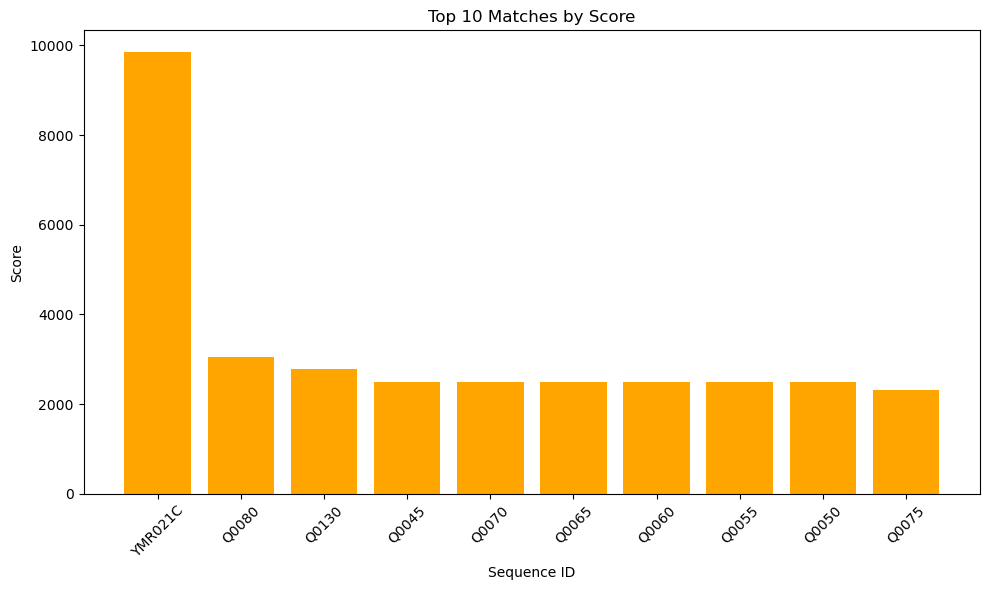

In [ ]:
import matplotlib.pyplot as plt

k = 5   # k-mer length
m = 20  # minimum diagonal matches
g = 3   # gap tolerance
q_len = len(query)
score_threshold = 0.5 * q_len # score threhold
n_top = "all" # Top kmers in this case we are going to use all kmers
print(f"Running FASTA variant with top {n_top} k-mers (k={k}, m={m}, threshold={score_threshold:.1f})")
hits = fasta_top_kmers(query, DB_FILE, k,n_top,m,g,score_threshold)

if not hits:
    print("No matches found above threshold.")
else:
    print("\nTop matches (seq_id:score);")
    for seq_id, score in hits[:10]:
        print(f"{seq_id}:{score}")
    top_id, top_score = hits[0]
    print(f"\nHighest match: {top_id} with score {top_score}")
    top_hits = hits[:10]
    seq_ids = [seq_id for seq_id, _ in top_hits]
    scores = [score for _, score in top_hits]

    plt.figure(figsize=(10, 6))
    plt.bar(seq_ids, scores,color='orange') # Plot the top 10 matches by score, x axis is sequence ID, y axis is score
    plt.xlabel('Sequence ID')
    plt.ylabel('Score')
    plt.title('Top 10 Matches by Score')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


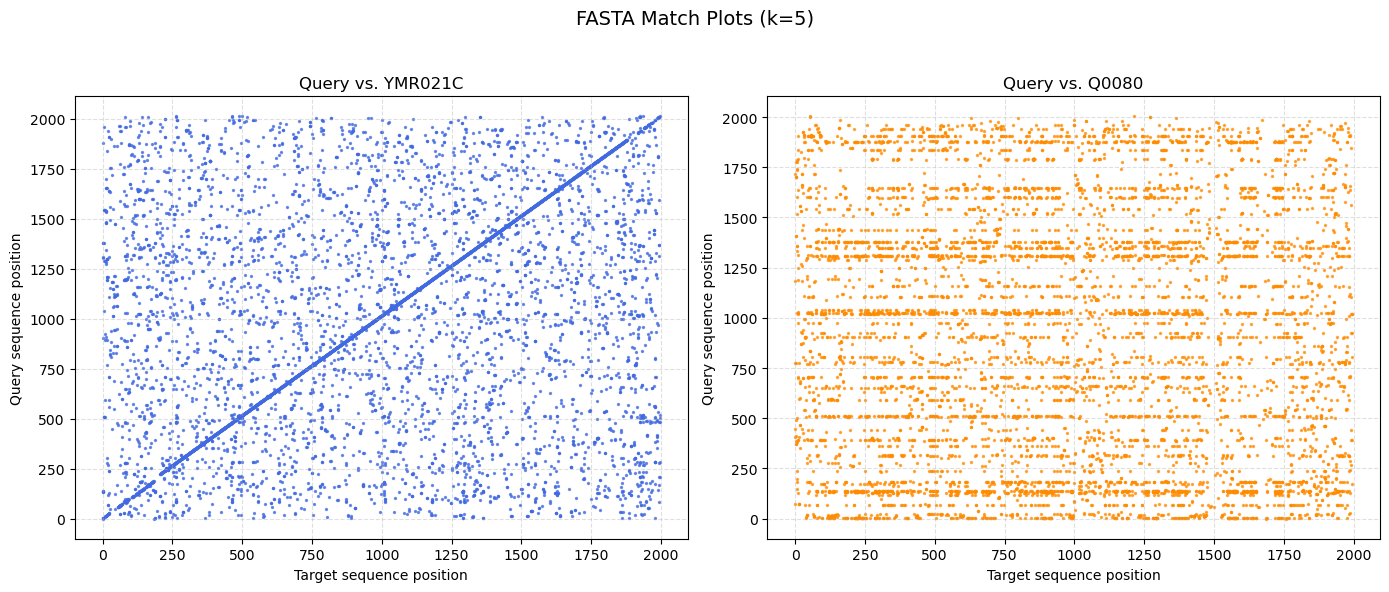

In [ ]:
# Create a dot plot visualization showing k-mer matches between query and target sequences

def plot_fasta_kmer_matches(ax, query_seq, target_seq, k, n, title, color):
    # Generate all k-mers from the query
    all_kmers = [query_seq[i:i + k] for i in range(len(query_seq) - k + 1)]
    if n == "all":
        top_kmers = set(all_kmers)
    else:
        # Count frequencies and pick top n
        kmer_counts = Counter(all_kmers)
        top_kmers = set(km for km, _ in kmer_counts.most_common(n))

    # Map selected k-mers to query positions
    query_positions = defaultdict(list)
    for i in range(len(query_seq) - k + 1):
        km = query_seq[i:i + k]
        if km in top_kmers:
            query_positions[km].append(i)

    # Collect matching (target, query) positions
    x_points, y_points = [], []
    for km, q_pos_list in query_positions.items():
        start = 0
        while True:
            idx = target_seq.find(km, start)
            if idx == -1:
                break
            for q_pos in q_pos_list:
                x_points.append(idx)
                y_points.append(q_pos)
            start = idx + 1

    # Plot
    ax.scatter(x_points, y_points, s=2, c=color, alpha=0.7) # Plot (target_pos, query_pos) pairs
    ax.set_xlabel('Target sequence position')
    ax.set_ylabel('Query sequence position')
    ax.set_title(title)
    ax.grid(True, linestyle='--', alpha=0.4)

# Load query
query = next(SeqIO.parse('data/query.fa', 'fasta')).seq

# Load YMR021C and Q0080
targets = {}
for rec in SeqIO.parse('data/all_yeast_genes_minplus1k.fa', 'fasta'):
    if rec.id in ['YMR021C', 'Q0080']: # Get only the top 2, by score, sequences from the database
        targets[rec.id] = rec.seq
    if len(targets) == 2:
        break

if 'YMR021C' not in targets or 'Q0080' not in targets:
    print("One or both target sequences not found!")
else:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    plot_fasta_kmer_matches(axes[0], str(query), str(targets['YMR021C']), k=5, n='all',
                            title='Query vs. YMR021C', color='royalblue')
    plot_fasta_kmer_matches(axes[1], str(query), str(targets['Q0080']), k=5, n='all',
                            title='Query vs. Q0080', color='darkorange')

    plt.suptitle('FASTA Match Plots (k=5)', fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


It is clear from the plotting that the YMR021C yeast gene has high sequence similarity with the query sequence, hence the dense, concentrated dots along the diagonal running from the bottom-left to top-right. The gene with the second highest score, Q0080, plotted on the right, does not have such similarity with the query and just a few horizontal banding patterns are visible.

---
### Highest match: YMR021C with score 9845
---

### Plotting topKmers vs Coverage 
**selecting most frequent kmers**


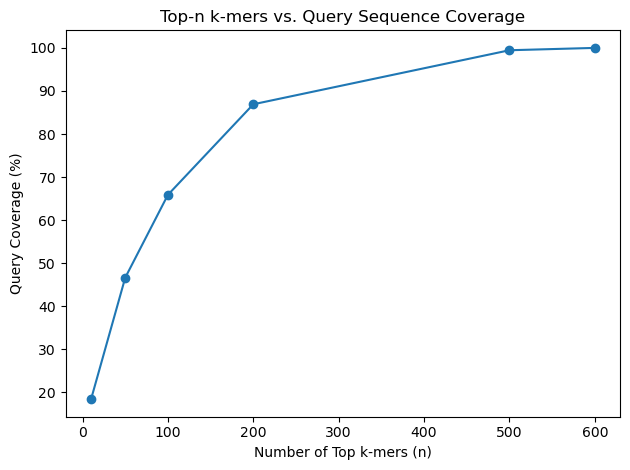

In [ ]:
from collections import Counter

# Count all k-mers in query
all_kmers = [query[i:i+k] for i in range(q_len - k + 1)]
kmer_counts = Counter(all_kmers)
unique_kmers = len(kmer_counts)

# Define n values up to total unique k-mers
ns = sorted([n for n in [10, 50, 100, 200, 500,600] if n <= unique_kmers])

# Compute coverage for each n
coverages = []
for n in ns:
    top_kmers = [km for km, _ in kmer_counts.most_common(n)]
    covered = [False] * q_len
    for km in top_kmers:
        start = 0
        while True:
            idx = query.find(km, start)
            if idx == -1:
                break
            for pos in range(idx, idx + k):
                covered[pos] = True
            start = idx + 1
    coverage_percent = sum(covered) / q_len * 100
    coverages.append(coverage_percent)

# Plot the results
plt.figure()
plt.plot(ns, coverages, marker='o')
plt.xlabel('Number of Top k-mers (n)')
plt.ylabel('Query Coverage (%)')
plt.title('Top-n k-mers vs. Query Sequence Coverage')
plt.tight_layout()
plt.show()


##### We can see that with just **150** *5-mers* we cover almost **80%** of the sequence thus will have somewhat sensitive results. 

In [11]:

k = 5   # k-mer length
m = 20  # minimum diagonal matches
q_len = len(query)
score_threshold = 0.5 * q_len # score threhold
n_top = 150 # Top kmers in this case we are going to use all kmers
print(f"Running FASTA variant with top {n_top} k-mers (k={k}, m={m}, g={g}, threshold={score_threshold:.1f})")
hits = fasta_top_kmers(query, DB_FILE, k,n_top,m,g,score_threshold)

if not hits:
    print("No matches found above threshold.")
else:
    print("\nTop matches (seq_id:score);")
    for seq_id, score in hits[:10]:
        print(f"{seq_id}:{score}")
    top_id, top_score = hits[0]
    print(f"\nHighest match: {top_id} with score {top_score}")

Running FASTA variant with top 150 k-mers (k=5, m=20, g=3, threshold=1008.5)


Scanning sequences: 100%|██████████| 5765/5765 [00:08<00:00, 684.12it/s]


Top matches (seq_id:score);
YMR021C:3485

Highest match: YMR021C with score 3485


### Increasing kmer size 

In [13]:

k = 50   # k-mer length
m = 20  # minimum diagonal matches
q_len = len(query)
score_threshold = 0.5 * q_len # score threhold
n_top = 'all' # Top kmers in this case we are going to use all kmers
print(f"Running FASTA variant with top {n_top} k-mers (k={k}, m={m}, g={g}, threshold={score_threshold:.1f})")
hits = fasta_top_kmers(query, DB_FILE, k,n_top,m,g,score_threshold)

if not hits:
    print("No matches found above threshold.")
else:
    print("\nTop matches (seq_id:score);")
    for seq_id, score in hits[:10]:
        print(f"{seq_id}:{score}")
    top_id, top_score = hits[0]
    print(f"\nHighest match: {top_id} with score {top_score}")

Running FASTA variant with top all k-mers (k=50, m=20, g=3, threshold=1008.5)


Scanning sequences: 100%|██████████| 5765/5765 [00:46<00:00, 124.14it/s]


Top matches (seq_id:score);
YMR021C:81400

Highest match: YMR021C with score 81400


### This runs very slowly, probably because of overeheading (big kmers means many unique kmers -overhead- and more expensive searches)

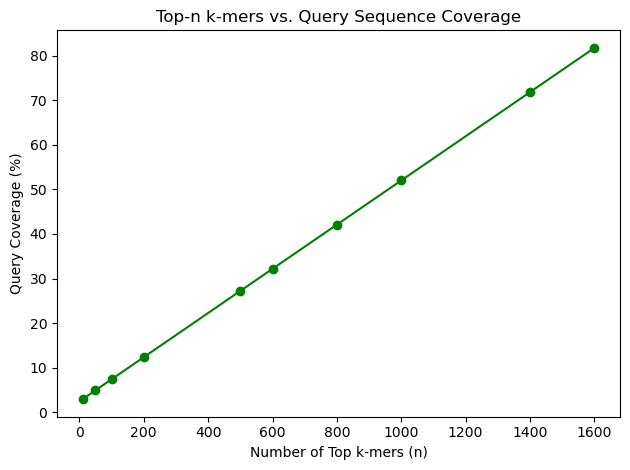

In [14]:
import matplotlib.pyplot as plt
from collections import Counter

k = 50

# Count all k-mers in query
all_kmers = [query[i:i+k] for i in range(q_len - k + 1)]
kmer_counts = Counter(all_kmers)
unique_kmers = len(kmer_counts)

# Define n values up to total unique k-mers
ns = sorted([n for n in [10, 50, 100, 200, 500,600,800,1000,1400,1600] if n <= unique_kmers])

# Compute coverage for each n
coverages = []
for n in ns:
    top_kmers = [km for km, _ in kmer_counts.most_common(n)]
    covered = [False] * q_len
    for km in top_kmers:
        start = 0
        while True:
            idx = query.find(km, start)
            if idx == -1:
                break
            for pos in range(idx, idx + k):
                covered[pos] = True
            start = idx + 1
    coverage_percent = sum(covered) / q_len * 100
    coverages.append(coverage_percent)

# Plot the results
plt.figure()
plt.plot(ns, coverages, marker='o',color='green')
plt.xlabel('Number of Top k-mers (n)')
plt.ylabel('Query Coverage (%)')
plt.title('Top-n k-mers vs. Query Sequence Coverage')
plt.tight_layout()
plt.show()


#### As we can see we need far more Top-50mers to reach ~80%, meaning that our analysis will likely be less meaningful.

In [15]:

k = 50   # k-mer length
m = 20  # minimum diagonal matches
q_len = len(query)
score_threshold = 0.5 * q_len # score threhold
n_top = 300 # Top kmers in this case we are going to use all kmers
print(f"Running FASTA variant with top {n_top} k-mers (k={k}, m={m}, g={g}, threshold={score_threshold:.1f})")
hits = fasta_top_kmers(query, DB_FILE, k,n_top,m,g,score_threshold)

if not hits:
    print("No matches found above threshold.")
else:
    print("\nTop matches (seq_id:score);")
    for seq_id, score in hits[:10]:
        print(f"{seq_id}:{score}")
    top_id, top_score = hits[0]
    print(f"\nHighest match: {top_id} with score {top_score}")

Running FASTA variant with top 300 k-mers (k=50, m=20, g=3, threshold=1008.5)


Scanning sequences: 100%|██████████| 5765/5765 [00:07<00:00, 785.01it/s]


Top matches (seq_id:score);
YMR021C:3850

Highest match: YMR021C with score 3850


We can see that with just 300 50-mers we manage to get the same results but since we include only 15% of the sequence in reality our analysis is not so sensitive

### Benchmarking

Running FASTA variant with top all k-mers (k=5, m=20, g=3, threshold=1008.5)


Scanning sequences: 100%|██████████| 5765/5765 [00:28<00:00, 202.31it/s]


Running FASTA variant with top all k-mers (k=5, m=20, g=3, threshold=1008.5)


Scanning sequences: 100%|██████████| 5765/5765 [00:08<00:00, 681.72it/s]


Running FASTA variant with top all k-mers (k=5, m=20, g=3, threshold=1008.5)


Scanning sequences: 100%|██████████| 5765/5765 [00:13<00:00, 419.47it/s]


Running FASTA variant with top all k-mers (k=5, m=20, g=3, threshold=1008.5)


Scanning sequences: 100%|██████████| 5765/5765 [00:16<00:00, 342.48it/s]


Running FASTA variant with top all k-mers (k=5, m=20, g=3, threshold=1008.5)


Scanning sequences: 100%|██████████| 5765/5765 [00:22<00:00, 254.36it/s]


Running FASTA variant with top all k-mers (k=50, m=20, g=3, threshold=1008.5)


Scanning sequences: 100%|██████████| 5765/5765 [00:46<00:00, 124.50it/s]


Running FASTA variant with top all k-mers (k=50, m=20, g=3, threshold=1008.5)


Scanning sequences: 100%|██████████| 5765/5765 [00:03<00:00, 1564.78it/s]


Running FASTA variant with top all k-mers (k=50, m=20, g=3, threshold=1008.5)


Scanning sequences: 100%|██████████| 5765/5765 [00:07<00:00, 796.39it/s]


Running FASTA variant with top all k-mers (k=50, m=20, g=3, threshold=1008.5)


Scanning sequences: 100%|██████████| 5765/5765 [00:09<00:00, 599.94it/s]


Running FASTA variant with top all k-mers (k=50, m=20, g=3, threshold=1008.5)


Scanning sequences: 100%|██████████| 5765/5765 [00:14<00:00, 403.87it/s]


Config       Runtime(s)       any hits?
k=5, n=all      28.5550            True
k=5, n=150       8.4890            True
k=5, n=300      13.7776            True
k=5, n=400      16.8654            True
k=5, n=600      22.7028            True
k=50, n=all     46.3503            True
k=50, n=150      3.7162           False
k=50, n=300      7.2722            True
k=50, n=400      9.6452            True
k=50, n=600     14.3141            True


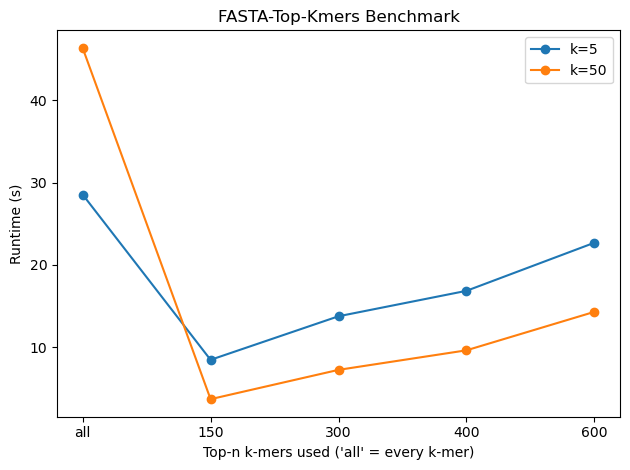

In [19]:
import time
# parameters
ks = [5, 50]
ns = ['all', 150, 300,400,600]


# Testing
labels = []
times  = []
hits_all = []

for k in ks:
    for n in ns:
        label = f"k={k}, n={n}"
        print(f"Running FASTA variant with top {n_top} k-mers (k={k}, m={m}, g={g}, threshold={score_threshold:.1f})")
        t0 = time.time()
        hitlist = fasta_top_kmers(query, DB_FILE, k, n, m, g, score_threshold)
        dt = time.time() - t0
        flag = any(hitlist)
        labels.append(label)
        times.append(dt)
        hits_all.append(flag)

# print summary
print(f"{'Config':<12} {'Runtime(s)':>10}  {'any hits?':>14}")
for lbl, dt, fl in zip(labels, times, hits_all):
    print(f"{lbl:<12} {dt:10.4f}  {str(fl):>14}")

plt.figure()
for i,k in enumerate(ks):
    x = list(range(len(ns)))        
    y = times[i*len(ns):(i+1)*len(ns)]
    plt.plot(x, y, marker='o', label=f'k={k}')
plt.xticks(x, ns)
plt.xlabel("Top-n k-mers used ('all' = every k-mer)")
plt.ylabel("Runtime (s)")
plt.title("FASTA-Top-Kmers Benchmark")
plt.legend()
plt.tight_layout()
plt.show()

---
### Results
Benchmarking clearly demonstrates how seed selection significantly impacts both runtime performance and query coverage. When utilizing **all** possible k-mers, runtimes dramatically increase, especially with larger *k* values. For instance, runtimes escalate from 25.3 seconds at *k*=5 to 45.4 seconds at *k*=50 due to the exhaustive search of every possible substring and increased computational overhead for longer k-mers.

In contrast, selecting only the **top 300** most frequent seeds reveals a stark difference in coverage efficiency. With shorter 5-mers, this strategy successfully covers over **90%** of the query's bases. However, coverage drastically diminishes with longer 50-mers, dropping below **15%**, as fewer long k-mers appear frequently enough to be effectively used.

Choosing too few seeds (e.g., the top 150) significantly accelerates runtimes—down to 6.6 seconds for 5-mers and 3.6 seconds for 50-mers—but this approach compromises accuracy, especially for larger k-mers. The strict diagonal-count threshold (e.g., 20) paired with limited seed choice results in inadequate coverage, missing matches for longer k-mers.

An intermediate strategy, such as employing approximately the top 300 seeds with shorter k-mer lengths, achieves an optimal balance. Although smaller k-mers inherently introduce greater ambiguity, using a strict diagonal-count threshold ("m") enhances sensitivity by effectively leveraging frequent "good" alignment, thus maintaining acceptable runtimes while significantly improving coverage (safer).    

* big `m` -> + sensitivity 
* big `k` -> + sensitivity
* So we have already fix for sensitivity


#### In all cases when we have a hit, the common hit and the one with the highest scores is **YMR021C** so this is our match (highest matching sequence)